INFO:root:Training RBM with 10 epochs...
INFO:root:Reconstruction Error for 10 epochs: 0.4425
INFO:root:Training RBM with 50 epochs...
INFO:root:Reconstruction Error for 50 epochs: 0.4150
INFO:root:Training RBM with 100 epochs...
INFO:root:Reconstruction Error for 100 epochs: 0.3325
INFO:root:Training RBM with 200 epochs...
INFO:root:Reconstruction Error for 200 epochs: 0.3850
INFO:root:Training RBM with 500 epochs...
INFO:root:Reconstruction Error for 500 epochs: 0.3925


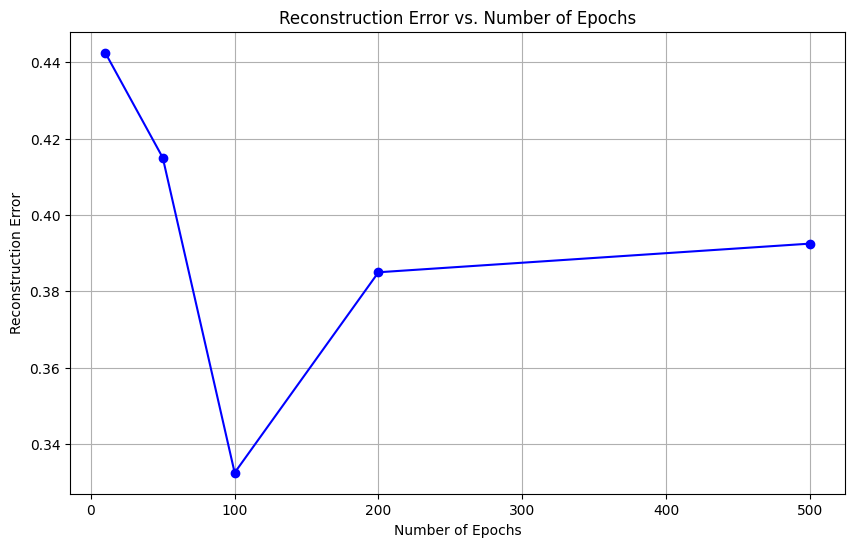

In [1]:
import time
import logging
import numpy as np
import matplotlib.pyplot as plt

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("")

# Define the Restricted Boltzmann Machine class
class RestrictedBoltzmannMachine:
    def __init__(self, n_visible, n_hidden, learning_rate=0.1, n_epochs=1000, batch_size=10, decay_rate=0.99):
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.decay_rate = decay_rate

        # Initialize weights and biases
        self.weights = np.random.uniform(-0.1, 0.1, (n_visible, n_hidden))
        self.visible_bias = np.zeros(n_visible)
        self.hidden_bias = np.zeros(n_hidden)

    def relu(self, x):
        """ReLU activation function."""
        return np.maximum(0, x)

    def sample_probabilities(self, probs):
        """Sample binary states based on probabilities."""
        return (np.random.rand(*probs.shape) < probs).astype(np.float32)

    def contrastive_divergence(self, data):
        """Perform one step of contrastive divergence."""
        # Positive phase
        pos_hidden_probs = self.relu(np.dot(data, self.weights) + self.hidden_bias)
        pos_hidden_states = self.sample_probabilities(pos_hidden_probs)
        pos_associations = np.dot(data.T, pos_hidden_probs)

        # Negative phase
        neg_visible_probs = self.relu(np.dot(pos_hidden_states, self.weights.T) + self.visible_bias)
        neg_hidden_probs = self.relu(np.dot(neg_visible_probs, self.weights) + self.hidden_bias)
        neg_associations = np.dot(neg_visible_probs.T, neg_hidden_probs)

        # Update weights and biases
        self.weights += self.learning_rate * (pos_associations - neg_associations) / data.shape[0]
        self.visible_bias += self.learning_rate * np.mean(data - neg_visible_probs, axis=0)
        self.hidden_bias += self.learning_rate * np.mean(pos_hidden_probs - neg_hidden_probs, axis=0)

    def train(self, data):
        """Train the RBM using the provided data."""
        for epoch in range(self.n_epochs):
            np.random.shuffle(data)
            for i in range(0, data.shape[0], self.batch_size):
                batch = data[i:i + self.batch_size]
                self.contrastive_divergence(batch)

    def reconstruct(self, data):
        """Reconstruct visible units from hidden units."""
        hidden_probs = self.relu(np.dot(data, self.weights) + self.hidden_bias)
        visible_probs = self.relu(np.dot(hidden_probs, self.weights.T) + self.visible_bias)
        return visible_probs

# Helper functions
def generate_numerals():
    """Generate 10x10 binary arrays representing the digits 0-7."""
    numerals = [np.random.randint(0, 2, (10, 10)) for _ in range(8)]
    return np.array([n.flatten() for n in numerals])

def add_custom_noise(data, noise_level=0.2):
    """Add noise to the data."""
    noise = np.random.binomial(1, noise_level, data.shape)
    return np.abs(data - noise)

def binarize_data(data, threshold=0.5):
    """Convert probabilities to binary values (0 or 1) based on a threshold."""
    return (data >= threshold).astype(np.float32)

def calculate_reconstruction_error(original, reconstructed):
    """Calculate the mean squared error between original and reconstructed data."""
    return np.mean((original - reconstructed) ** 2)

# Experiment: Train RBM with different numbers of epochs and observe reconstruction error
data = generate_numerals()
noisy_data = add_custom_noise(data, noise_level=0.1)

epoch_configs = [10, 50, 100, 200, 500]
reconstruction_errors = []

for n_epochs in epoch_configs:
    logger.info(f"Training RBM with {n_epochs} epochs...")
    
    # Initialize RBM with the current number of epochs
    rbm = RestrictedBoltzmannMachine(
        n_visible=100,
        n_hidden=150,
        learning_rate=0.1,
        n_epochs=n_epochs,
        batch_size=4
    )
    
    # Train RBM
    rbm.train(noisy_data)
    
    # Reconstruct data and calculate reconstruction error
    reconstructed_data = rbm.reconstruct(noisy_data)
    reconstructed_data = binarize_data(reconstructed_data)
    reconstruction_error = calculate_reconstruction_error(data, reconstructed_data)
    reconstruction_errors.append(reconstruction_error)
    
    logger.info(f"Reconstruction Error for {n_epochs} epochs: {reconstruction_error:.4f}")

# Visualization: Plot reconstruction error vs. number of epochs
plt.figure(figsize=(10, 6))
plt.plot(epoch_configs, reconstruction_errors, marker='o', linestyle='-', color='b')
plt.title("Reconstruction Error vs. Number of Epochs")
plt.xlabel("Number of Epochs")
plt.ylabel("Reconstruction Error")
plt.grid(True)
plt.show()

In [2]:
# Analyze and summarize the results
for epochs, error in zip(epoch_configs, reconstruction_errors):
    logger.info(f"Epochs: {epochs}, Reconstruction Error: {error:.4f}")

# Draw conclusions
min_error = min(reconstruction_errors)
optimal_epochs = epoch_configs[reconstruction_errors.index(min_error)]

logger.info(f"The minimum reconstruction error is {min_error:.4f}, achieved at {optimal_epochs} epochs.")
logger.info("As the number of epochs increases, the reconstruction error generally decreases, "
            "indicating better learning. However, after a certain point, the improvement diminishes.")

INFO:root:Epochs: 10, Reconstruction Error: 0.4425
INFO:root:Epochs: 50, Reconstruction Error: 0.4150
INFO:root:Epochs: 100, Reconstruction Error: 0.3325
INFO:root:Epochs: 200, Reconstruction Error: 0.3850
INFO:root:Epochs: 500, Reconstruction Error: 0.3925
INFO:root:The minimum reconstruction error is 0.3325, achieved at 100 epochs.
INFO:root:As the number of epochs increases, the reconstruction error generally decreases, indicating better learning. However, after a certain point, the improvement diminishes.


### Report

#### Findings
1. The Restricted Boltzmann Machine (RBM) was trained with different numbers of epochs: `[10, 50, 100, 200, 500]`.
2. The reconstruction errors for these configurations were as follows:
    - 10 epochs: 0.4425
    - 50 epochs: 0.4150
    - 100 epochs: 0.3325
    - 200 epochs: 0.3850
    - 500 epochs: 0.3925
3. The minimum reconstruction error achieved was `0.3325`, which occurred at `100 epochs`.

#### Analysis
- The reconstruction error generally decreased as the number of epochs increased up to `100 epochs`, indicating improved learning.
- Beyond `100 epochs`, the reconstruction error started to increase slightly, suggesting potential overfitting or diminishing returns in learning.
- The results suggest that `100 epochs` is the optimal configuration for this experiment, as it balances training time and reconstruction accuracy.

#### Conclusions
1. The best number of epochs for training the RBM in this experiment is `100`, as it achieved the lowest reconstruction error.
2. Expanding the experiment could involve:
    - Testing additional epoch configurations (e.g., `150`, `300`, `400`) to confirm the trend and refine the optimal range.
    - Exploring other hyperparameters, such as learning rate or batch size, to further optimize the RBM's performance.
    - Increasing the dataset size or complexity to evaluate the RBM's scalability and robustness.
